In [1]:
import mne
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [7]:
SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
filename_epoch = SAVE_EPOCH_ROOT +  'epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif'

#Read Epochs
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True, verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
subset.crop(tmin=-0.45,tmax=0.45)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<ipython-input-7-5428fbcee6a7>:9: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset.crop(tmin=-0.45,tmax=0.45)


<EpochsFIF  |   876 events (all good), -0.4 - 0.448 sec, baseline [-0.4, 0], ~183.9 MB, data loaded, with metadata,
 'pred/down/non': 216
 'pred/left/non': 224
 'pred/right/non': 219
 'pred/up/non': 217>

## Some preprocessing

In [8]:
if subset['Block==6'].metadata.Ptrn_Type.values.shape[0]>0:
       main_ptrn = subset['Block==6'].metadata.Ptrn_Type.values[0]
else:
       main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]

# only early blocks
subset = subset['Block<7'].copy()
subset = subset['Block>2'].copy()

# Group data based on the previous trial
Grp1 = subset['Trgt_Loc_prev==1'].copy()
Grp2 = subset['Trgt_Loc_prev==2'].copy()
Grp3 = subset['Trgt_Loc_prev==3'].copy()
Grp4 = subset['Trgt_Loc_prev==4'].copy()

Grp1._data = (Grp1._data - np.mean(Grp1._data)) / np.std(Grp1._data)
Grp2._data = (Grp2._data - np.mean(Grp2._data)) / np.std(Grp2._data)
Grp3._data = (Grp3._data - np.mean(Grp3._data)) / np.std(Grp3._data)
Grp4._data = (Grp4._data - np.mean(Grp4._data)) / np.std(Grp4._data)

# Autocorrelation

In [16]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

352 129 213


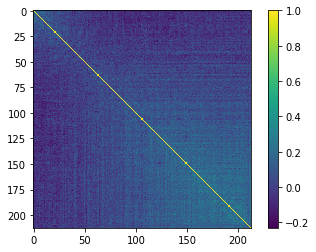

In [63]:
trialInd = subset._data.shape[0]
chanInd  = subset._data.shape[1]
timeInd  = subset._data.shape[2]
print(trialInd, chanInd, timeInd)

dt = np.mean(subset._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_r = generate_correlation_map(x1, x1)
plt.imshow(map_r)
plt.colorbar()
     

In [64]:
map_r

array([[ 1.        ,  0.25533999,  0.13578316, ...,  0.01015997,
        -0.09168387, -0.06847411],
       [ 0.25533999,  1.        ,  0.19583798, ..., -0.02793118,
        -0.0861775 , -0.11443345],
       [ 0.13578316,  0.19583798,  1.        , ..., -0.06345703,
        -0.05729772, -0.09079245],
       ...,
       [ 0.01015997, -0.02793118, -0.06345703, ...,  1.        ,
         0.18180659,  0.15449776],
       [-0.09168387, -0.0861775 , -0.05729772, ...,  0.18180659,
         1.        ,  0.20011019],
       [-0.06847411, -0.11443345, -0.09079245, ...,  0.15449776,
         0.20011019,  1.        ]])

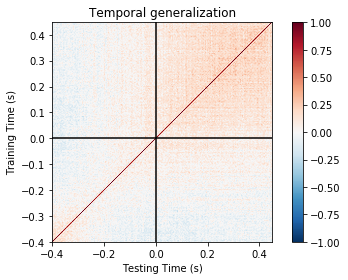

In [65]:
fig, ax = plt.subplots(1, 1)
plt.tight_layout()
im = ax.imshow(map_r, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=subset.times[[0, -1, 0 , -1]], vmin=-1, vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

(2, 2)


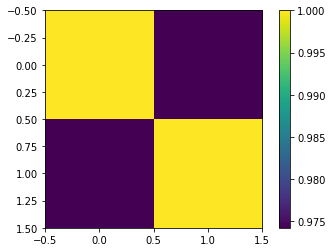

In [59]:
# x1 = np.random.rand(32,12)
# x2 = np.random.rand(32,12)
x1=np.asarray([[1,3,5,6],[2,5,6,7]])
x2=np.asarray([[3,5,6,2],[4,5,6,8]])

map_r = generate_correlation_map(x1, x1)
print(map_r.shape)
plt.imshow(map_r)
plt.colorbar()



# Plot functions

In [11]:
def smooth(y, window, mode):
    box = np.ones(window)/window
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_scores(scores):
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=0., vmax=1.)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_scores_diag(scores_diag, apply_smooth):
    if apply_smooth:
        window=50
        mode='valid'
        scores_diag = smooth(y, window, mode)
        print(subset.times.shape)
        print(y_smooth.shape)
    fig, ax = plt.subplots()
    ax.plot(subset.times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')
    plt.tight_layout()
    plt.show()

# General decoder params

In [12]:
nSplits=5
scoring='roc_auc'
randState=0
maxIter=10000

# Set up a decoder

## Using StandardScaler from sklearn.preprocessing:
### mne.decoding.Scaler
    scales each channel 
    using mean and standard deviation computed across all of its time points and epochs. 
### mne.decoding.Vectorizer
    Scikit-learn API provides functionality to chain transformers and estimators by using sklearn.pipeline.Pipeline. We can construct decoding pipelines and perform cross-validation and grid-search. However scikit-learn transformers and estimators generally expect 2D data (n_samples * n_features), whereas MNE transformers typically output data with a higher dimensionality (e.g. n_samples * n_channels * n_frequencies * n_times). A Vectorizer therefore needs to be applied between the MNE and the scikit-learn steps 
###  sklearn.preprocessing.StandardScaler offered by scikit-learn
    These scale each classification feature, e.g. each time point for each channel, 
    with mean and standard deviation computed across epochs

In [14]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))

time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

## StratifiedKFold

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

shuffle: boolean
Whether to shuffle each class’s samples before splitting into batches.

In [37]:
cv = StratifiedtKFold(n_splits=5, shuffle=True)

## Set up the data for a decoder

In [38]:
Grp_data = Grp1
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

In [39]:
score_wcv = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score_wcv = np.mean(score_wcv, axis=0) #scores with cv
score_diag_wcv = np.diag(score_wcv)
score_substract_wcv = score_diag_wcv - 0.5
scores_wcv = (score_wcv.copy(), score_diag_wcv.copy(), score_substract_wcv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

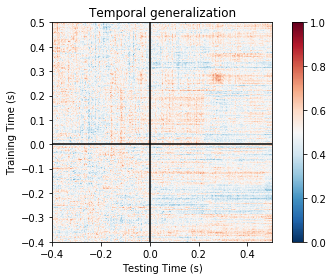

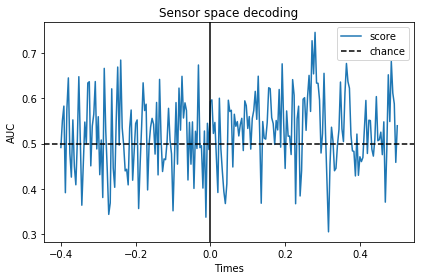

In [76]:
plot_scores(scores_wcv[0])
plot_scores_diag(scores_wcv[1], 0)

## 2. Getting scores after fit/train

In [80]:
Grp_data = Grp1
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

time_gen.fit(X=X ,y=y)
score_wocv = time_gen.score(X=X, y=y) #scores without cv
score_diag_wocv = np.diag(score_wocv)
scores_wocv = (score_wocv.copy(), score_diag_wocv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   


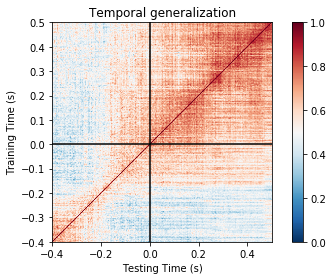

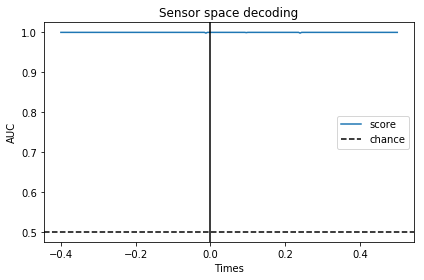

In [83]:
plot_scores(scores_wocv[0])
plot_scores_diag(scores_wocv[1], 0)

## 3. Set up a decoder using Scaler from mne decoding

In [17]:
Grp_data = Grp1
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

### mne.decoding.Scaler
    scales each channel 
    using mean and standard deviation computed across all of its time points and epochs. 
### mne.decoding.Vectorizer
    Scikit-learn API provides functionality to chain transformers and estimators by using sklearn.pipeline.Pipeline. We can construct decoding pipelines and perform cross-validation and grid-search. However scikit-learn transformers and estimators generally expect 2D data (n_samples * n_features), whereas MNE transformers typically output data with a higher dimensionality (e.g. n_samples * n_channels * n_frequencies * n_times). A Vectorizer therefore needs to be applied between the MNE and the scikit-learn steps 

In [102]:
maxIter_3=100000 #with maxIter, gave warnings "increase the num of iterations, ConvergenceWarning"
le = LabelEncoder()
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LinearModel(LinearSVC(random_state=randState, max_iter=maxIter_3)))

In [103]:
time_gen = GeneralizingEstimator(clf, scoring=scoring, n_jobs=1,verbose=True)

In [104]:
cv = StratifiedKFold(n_splits=nSplits, shuffle=True)

In [109]:
score2_wcv = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score2_wcv = np.mean(score2_wcv, axis=0) 
score2_diag_wcv = np.diag(score2_wcv)
scores2_wcv = (score2_wcv.copy(), score2_diag_wcv.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

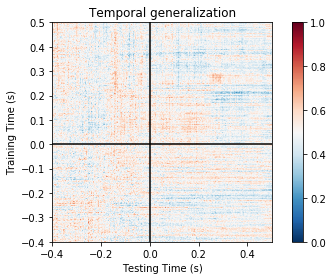

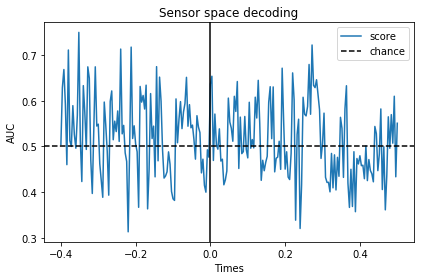

In [110]:
plot_scores(scores2_wcv[0])
plot_scores_diag(scores2_wcv[1], 0)

## 4. repeatedStritifiedKFold from sklearn
Repeated Stratified K-Fold cross validator.

Repeats Stratified K-Fold n times with different randomization in each repetition.


In [200]:
cv = RepeatedStratifiedKFold(n_splits=nSplits, n_repeats=3, random_state=randState)
print(randState)

0


In [113]:
score_rskf_o = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

In [114]:
print(score_rskf_o.shape)
score_rskf = np.mean(score_rskf_o, axis=0) 
score_diag_rskf = np.diag(score_rskf)
scores_rskf = (score_rskf.copy(), score_diag_rskf.copy())

(15, 226, 226)


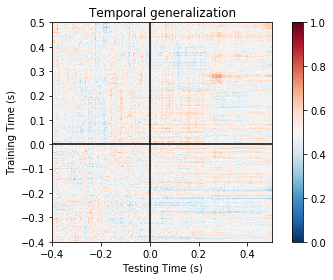

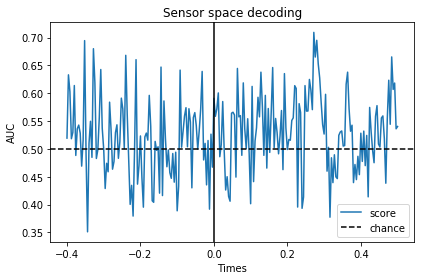

In [119]:
plot_scores(score_rskf)
plot_scores_diag(score_diag_rskf, 0)

### RepeatedStratifiedKFold with another random state (42 this time, previously it was 0)

In [23]:
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

In [24]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))

In [25]:
time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

In [26]:
randState=42
cv = RepeatedStratifiedKFold(n_splits=nSplits, n_repeats=3, random_state=randState)
print(randState)

42


In [27]:
score_rskf2           = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score_rskf2           = np.mean(score_rskf2, axis=0)
score_diag_rskf2      = np.diag(score_rskf2)
score_substract_rskf2 = score_diag_rskf2 - 0.5
scores_rskf2          = (score_rskf2.copy(), score_diag_rskf2.copy(), score_substract_rskf2.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

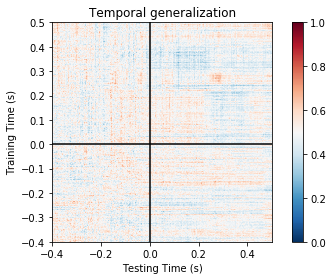

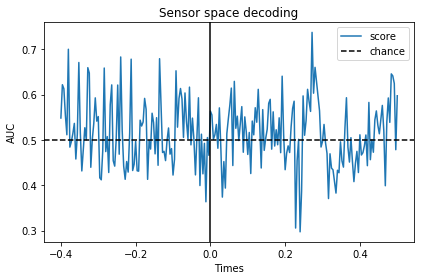

In [29]:
plot_scores(scores_rskf2[0])
plot_scores_diag(scores_rskf2[1], 0)

## Alex Gramfort suggestion:
### Set random state
### Use StratifiedShuffleSplit
Stratified ShuffleSplit cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.



In [178]:
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

In [179]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))

In [180]:
time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

In [184]:
cv = StratifiedShuffleSplit(n_splits=5, random_state=42)                                                    

In [185]:
score_sss           = cross_val_multiscore(time_gen, X, y, cv=cv, n_jobs=1)
score_sss           = np.mean(score_sss, axis=0)
score_diag_sss      = np.diag(score_sss)
score_substract_sss = score_diag_sss - 0.5
scores_sss          = (score_sss.copy(), score_diag_sss.copy(), score_substract_sss.copy())

[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[............................................................] 100.00% Scoring GeneralizingEstimator |   
[............................................................] 100.00% Fitting GeneralizingEstimator |   
[.............................................

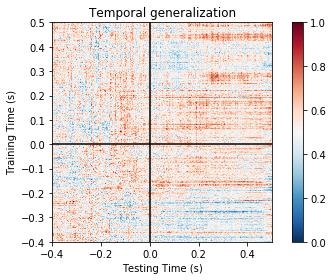

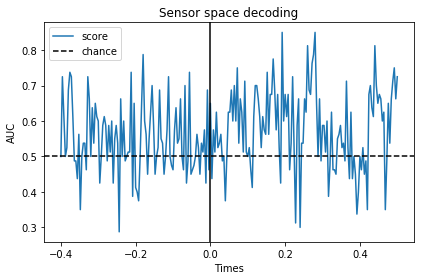

In [186]:
plot_scores(scores_sss[0])
plot_scores_diag(scores_sss[1], 0)

# Statistical analysis

## Plot functions

In [31]:
def do_time_bin(data, indx, sbt):
    if sbt==0:
        avgs=np.zeros(len(indx))
        bs=np.array(np.split(data, indx))
        for ii in range(len(indx)):
            avgs[ii]=bs[ii].mean()
    if sbt==1:
         avgs=np.zeros([data.shape[0],len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs=np.array(np.split(data[jj,:], indx))
             for ii in range(len(indx)):
                 aa[ii]=bs[ii].mean()
             avgs[jj,:]=aa
    if sbt==2:
         avgs=np.zeros([len(indx),len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs1=np.array(np.split(data[jj,:], indx))
             bs2=np.array(np.split(data[:,jj], indx))
             for ii in range(len(indx)):
                 avgs[ii,:]=bs1[ii].mean()
                 avgs[:,ii]=bs2[ii].mean()

    return avgs

In [32]:
def set_fonts():
    from matplotlib.font_manager import FontProperties

    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

def plot_scores_stat(diag_scores, clusts):
    font=set_fonts();
    [t_obs, clusters, clusters_pv, H0] = clusts
    # binned times
    times=np.asarray([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])
    extent_times=subset.times[[0, -1, 0, -1]]
    
    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.plot(times, diag_scores, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    plt.ylim([0.43,0.65])
    ax.axvline(.0, color='k', linestyle='-')

    for i_clu, clu_idx in enumerate(clusters):
        clu_idx=clu_idx[0]
        print(clu_idx)
        # unpack cluster information, get unique indices
        if clusters_pv[i_clu] <= 0.05:
            h = plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1],
                            color='r', alpha=0.3)
            plt.legend((h, ), ('cluster p-value < 0.05', ))
        else:
            plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1], color=(0.3, 0.3, 0.3),
                        alpha=0.3)

    plt.tight_layout()
    plt.xlabel('Times',  fontproperties=font, fontsize=12, fontweight='bold')
    plt.ylabel('AUC', fontproperties=font, fontsize=12, fontweight='bold')#, labelpad=16,)
    plt.title('Decoding over time', fontproperties=font, fontweight='bold', fontsize=16)

    plt.legend(fontsize=11)
    plt.tight_layout()

## Statistial analysis

In [33]:
def stat_anal(scores_pck):
    indx=[26,51,76,101,126,151,176,201]
    score, score_diag, score_subtract = scores_pck
    binned_score = do_time_bin(score, indx, 2)
    binned_score_diag = do_time_bin(score_diag, indx, 0)
    binned_score_subtract = do_time_bin(score_subtract, indx, 0)
    print(score_subtract.shape)
    score_subtract=score_subtract[:, np.newaxis, np.newaxis] # [:,:, np.newaxis] when added more subjects
    print(score_subtract.shape)
    t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(score_subtract, tail=0)
    clust_pck = [t_obs, clusters, clusters_pv, H0]
    
    return binned_score_diag, clust_pck

### Stat analysys for StratifiedKFold with shuffle = True

In [217]:
binned_score_diag_wcv, clust_pck_wcv = stat_anal(scores_wcv)

(226,)
(226, 1, 1)
Using a threshold of 1.970563
stat_fun(H1): min=4.488823 max=4.488823
Running initial clustering
Found 1 clusters
Permuting 1023 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Done.


[0]


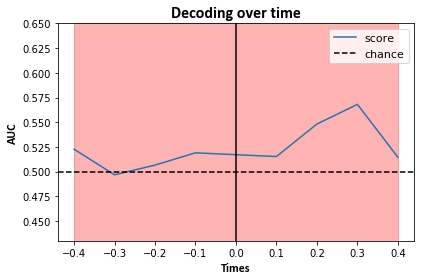

In [219]:
plot_scores_stat(binned_score_diag_wcv, clust_pck_wcv)

### Stat analysys for RepeatedStratifiedKFold with random state = 42

In [35]:
binned_score_diag_rskf2, clust_pck_rskf2 = stat_anal(scores_rskf2)

(226,)
(226, 1, 1)
Using a threshold of 1.970563
stat_fun(H1): min=3.015597 max=3.015597
Running initial clustering
Found 1 clusters
Permuting 1023 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Done.


[0]


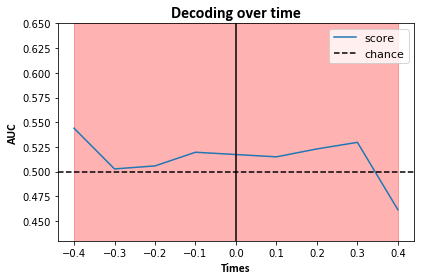

In [36]:
plot_scores_stat(binned_score_diag_rskf2, clust_pck_rskf2)

### Stat analysis for stratified shuffle split result (Alex suggestion)

In [224]:
binned_score_diag_sss, clust_pck_sss = stat_anal(scores_sss)

(226,)
(226, 1, 1)
Using a threshold of 1.970563
stat_fun(H1): min=9.330805 max=9.330805
Running initial clustering
Found 1 clusters
Permuting 1023 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Done.


[0]


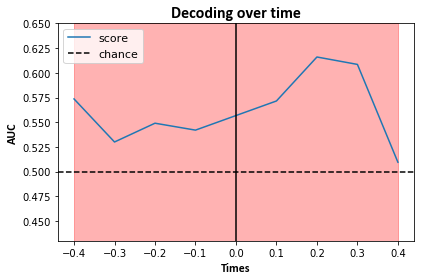

In [225]:
plot_scores_stat(binned_score_diag_sss, clust_pck_sss)